# Notebook for practical exercises | Week #5 Lesson #3

## Introduction

This notebook contains practical hands-on exercises for the lesson about *Quantifying Uncertainty in AI Models*.

After this session, you will know how to evaluate and improve the performance of a classifier for a real-world segmentation problem:
- Load previously trained segmentation model.
- Perform Monte Carlo dropout inference and visualize uncertainty maps.
- Perform the calibration curve
- Compute ECE with M = 10 bins.
- Plot reliability diagrams before and after applying temperature scaling.
- Identify most uncertain cases with the highest variance and discuss whether they correspond to difficult or ambiguous predictions.

## Dataset

We will use the [The Brain Resection Multimodal Imaging Database](https://www.cancerimagingarchive.net/collection/remind/) [1]. The Brain Resection Multimodal Imaging Database (ReMIND) contains pre- and intra-operative brain MRI collected on 114 consecutive patients who were surgically treated with image-guided tumor resection between 2018 and 2022.

[1] Juvekar, P., Dorent, R., Kögl, F., Torio, E., Barr, C., Rigolo, L., Galvin, C., Jowkar, N., Kazi, A., Haouchine, N., Cheema, H., Navab, N., Pieper, S., Wells, W. M., Bi, W. L., Golby, A., Frisken, S., & Kapur, T. (2023). The Brain Resection Multimodal Imaging Database (ReMIND) (Version 1) [dataset]. The Cancer Imaging Archive. [https://doi.org/10.7937/3RAG-D070](https://doi.org/10.7937/3RAG-D070)

In [3]:
#@title Import libraries
!pip install pydicom SimpleITK grad-cam albumentations -q
!pip install -U segmentation-models-pytorch -q
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import warnings
warnings.filterwarnings(action="ignore")
os.environ["PYTHONWARNINGS"] = "ignore"


import argparse
import math
from glob import glob

import albumentations as A
import numpy as np
import pandas as pd
import SimpleITK as sitk
sitk.ProcessObject.SetGlobalWarningDisplay(False)
import torch
import torch.nn as nn
import torch.optim as optim
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import cv2

sitk.ProcessObject_SetGlobalWarningDisplay(False)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 59.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 8.7 MB/s eta 0:00:00


### Download

If needed, run the following cells to download and unzip the dataset. If you already have the dataset downloaded, comment the two lines.

<div class="alert alert-block alert-danger">
<b>Replace the <code>DATA_PATH</code> with the path where you want to store the data folder. By default, it will be stored at the root of this repository.</b> <br>
<b>If you have already downloaded the dataset, comment the following cell by adding a <code>#</code> before the <code>!</code></b>
</div>

In [4]:
DATA_PATH = './'

!curl https://uni-bonn.sciebo.de/s/s1t8QUZ02MF1Qoh/download --output {DATA_PATH}/data.zip
!unzip {DATA_PATH}/data.zip -d {DATA_PATH}

Streaming output truncated to the last 5000 lines.
  inflating: ./data/ReMIND/sub-097/anat/T1w/1-055.dcm  
  inflating: ./__MACOSX/data/ReMIND/sub-097/anat/T1w/._1-055.dcm  
  inflating: ./data/ReMIND/sub-097/anat/T1w/1-032.dcm  
  inflating: ./__MACOSX/data/ReMIND/sub-097/anat/T1w/._1-032.dcm  
  inflating: ./data/ReMIND/sub-097/anat/T1w/1-026.dcm  
  inflating: ./__MACOSX/data/ReMIND/sub-097/anat/T1w/._1-026.dcm  
  inflating: ./data/ReMIND/sub-097/anat/T1w/1-146.dcm  
  inflating: ./__MACOSX/data/ReMIND/sub-097/anat/T1w/._1-146.dcm  
  inflating: ./data/ReMIND/sub-097/anat/T1w/1-152.dcm  
  inflating: ./__MACOSX/data/ReMIND/sub-097/anat/T1w/._1-152.dcm  
  inflating: ./data/ReMIND/sub-097/anat/T1w/1-185.dcm  
  inflating: ./__MACOSX/data/ReMIND/sub-097/anat/T1w/._1-185.dcm  
  inflating: ./data/ReMIND/sub-097/anat/T1w/1-191.dcm  
  inflating: ./__MACOSX/data/ReMIND/sub-097/anat/T1w/._1-191.dcm  
  inflating: ./data/ReMIND/sub-097/anat/T1w/1-190.dcm  
  inflating: ./__MACOSX/data/ReM

Download the previously trained model

In [5]:
!curl https://uni-bonn.sciebo.de/s/WxaG6rbBFKHwa5X/download/fcn_segmentation020_dice0.5179.pt --output {DATA_PATH}/fcn_segmentation020_dice0.5179.pt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  124M  100  124M    0     0  86.5M      0  0:00:01  0:00:01 --:--:-- 86.5M


### Dataset Class

Similarly to what we have done for previous weeks we to create a `Dataset` class for the segmentation task.
Observe the following cell and compare with the classes we created in lesson #1.

In [6]:
# Load and observe available data
clinical_df = pd.read_csv(f'{DATA_PATH}/data/ReMIND/ReMIND_metadata.csv')
clinical_df.head() # Print the 5 fist rows of the dataframe

,Case Number,Age,Sex,Race,Ethnicity,Laterality,Previous Craniotomy,WHO Grade,Histopathology
0,1,41,Male,White,Not Hispanic,Right,No,3,Astrocytoma
1,2,22,Female,White,Not Hispanic,Right,No,2,Astrocytoma
2,3,30,Male,Asian,Not Hispanic,Left,No,2,Oligodendroglioma
3,4,23,Male,White,Hispanic,Left,No,1,Dysembryoplastic neuroepithelial tumor
4,5,27,Male,White,Not Hispanic,Right,No,Not assigned,Non-tumor epileptogenic brain parenchyma and g...


In [7]:
#@title Load data helper
class SegmentationDataset(Dataset):

    def __init__(self, clinical_df: pd.DataFrame, data_dir: str, size: int = 512, augment: bool = True):
        self.data_dir = data_dir
        self.size = size
        self.slices: list[tuple[np.ndarray, np.ndarray]] = []  # (img_slice, mask_slice)

        if augment:
            self.image_t = A.Compose(
                [
                    A.Resize(int(size), int(size), interpolation=0, p=1.),
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5),
                    A.Normalize(mean=0.0, std=1.0),
                    ToTensorV2(),
                ]
            )
            self.mask_t = A.Compose(
                [
                    A.Resize(size, size, interpolation=0),
                    ToTensorV2(transpose_mask=True),
                ]
            )
        else:
            self.image_t = A.Compose([A.Resize(size, size, interpolation=0), A.Normalize(0.0, 1.0), ToTensorV2()])
            self.mask_t = A.Compose([A.Resize(size, size, interpolation=0), ToTensorV2(transpose_mask=True)])

        for patient, _ in tqdm(
            zip(clinical_df["Case Number"], clinical_df["WHO Grade"]),
            total=len(clinical_df),
            desc="Indexing slices",
        ):
            idx = str(patient).zfill(3)
            img_dir = glob(f"{data_dir}/data/ReMIND/sub-{idx}/anat/T1w*")
            seg_path = glob(f"{data_dir}/data/ReMIND/sub-{idx}/seg/ReMIND-{idx}-preop-SEG-tumor-*.nrrd")
            if not img_dir or not seg_path:
                continue

            # Load volumes once – keep in RAM temporarily.
            img_sitk = load_dicom_series_to_3d_image(img_dir[0])
            img_np = sitk.GetArrayFromImage(img_sitk)  # (Z, H, W)

            mask_sitk = sitk.ReadImage(seg_path[0])
            mask_sitk = reconstruct_mask_in_image_space(mask_sitk, img_sitk)
            mask_np = sitk.GetArrayFromImage(mask_sitk).astype(np.uint8)

            assert img_np.shape == mask_np.shape, "Image/mask dim mismatch"

            # For each axial slice, append if any tumor present.
            for k in range(img_np.shape[0]):
                if mask_np[k].any():
                    self.slices.append((img_np[k], mask_np[k]))

    def __len__(self):
        return len(self.slices)

    def __getitem__(self, idx: int):
        img_slice, mask_slice = self.slices[idx]
        img_slice = img_slice.astype(np.float32)
        transformed = self.image_t(image=img_slice, mask=mask_slice)
        img_t = transformed["image"].float()
        mask_t = transformed["mask"].float()
        mask_t = mask_t.unsqueeze(0)
        return img_t, mask_t

# Helper functions to read the dicom and reconstruct the mask in image space
def load_dicom_series_to_3d_image(series_path: str) -> sitk.Image:
    """Read a DICOM series (folder full of slices) into a 3‑D SimpleITK image."""
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(series_path)
    reader.SetFileNames(dicom_names)
    img = reader.Execute()
    return img


def reconstruct_mask_in_image_space(mask_sitk: sitk.Image, reference_image: sitk.Image) -> sitk.Image:
    """Resample *mask_sitk* into the physical space & grid of *reference_image*."""
    return sitk.Resample(
        mask_sitk,
        reference_image,
        sitk.Transform(),
        sitk.sitkNearestNeighbor,
        0,
        mask_sitk.GetPixelID(),
    )

def dice_coefficient(logits, targets, smooth=1.0):
    """Calculates the Dice coefficient metric."""
    preds = (torch.sigmoid(logits) > 0.5).float()

    # Flatten both tensors to a 1D array
    preds_flat = preds.view(-1)
    targets_flat = targets.view(-1)

    intersection = (preds_flat * targets_flat).sum()

    # Use the 'smooth' argument, not 'self.smooth'
    union = preds_flat.sum() + targets_flat.sum()
    dice_score = (2. * intersection + smooth) / (union + smooth)

    return dice_score

def inference(model, loader, device):
    model.eval()
    val_loss = 0.0
    val_dice = 0.0
    with torch.no_grad():
        for imgs, masks in tqdm(loader, desc="Inference", leave=False):
            imgs, masks = imgs.to(device), masks.to(device)
            logits = model(imgs)
            val_dice += dice_coefficient(logits, masks, smooth=1e-6).item()
    return val_dice / len(loader)

# Splits
histopathology_counts = clinical_df['Histopathology'].value_counts()
to_replace = histopathology_counts[histopathology_counts <= 2].index
clinical_df['Histopathology'] = clinical_df['Histopathology'].replace(to_replace, 'Other')
clinical_df['Histopathology'].value_counts()
excluded_patients = [7, 16, 4, 19, 22, 23, 27, 35, 41, 43, 47, 60, 76, 92, 95, 114]
clinical_df = clinical_df[~clinical_df['Case Number'].isin(excluded_patients)]
print(f"Number of patients after exclusion: {len(clinical_df)}")
patient_data = clinical_df[['Case Number', 'Histopathology']].drop_duplicates().set_index('Case Number')
patient_list = patient_data.index.to_numpy()
patient_labels = patient_data['Histopathology'].to_numpy()
patient_train, patient_temp, labels_train, labels_temp = train_test_split(
    patient_list,
    patient_labels,
    test_size=0.3, # 30% of data will be for validation and testing
    stratify=patient_labels,
    random_state=42
)
patient_val, patient_test, _, _ = train_test_split(
    patient_temp,
    labels_temp,
    test_size=(2/3), # 20% is 2/3 of 30%
    stratify=labels_temp,
    random_state=42
)
train_df = clinical_df[clinical_df['Case Number'].isin(patient_train)]
val_df = clinical_df[clinical_df['Case Number'].isin(patient_val)]
test_df = clinical_df[clinical_df['Case Number'].isin(patient_test)]

print(f"Total patients: {len(patient_list)}")
print(f"Training patients:   {len(patient_train)} (~{len(patient_train)/len(patient_list):.0%})")
print(f"Validation patients: {len(patient_val)} (~{len(patient_val)/len(patient_list):.0%})")
print(f"Test patients:       {len(patient_test)} (~{len(patient_test)/len(patient_list):.0%})")
print("Stratification check (Histopathology distribution):")
print("\nTraining Set Distribution:\n", train_df['Histopathology'].value_counts(normalize=True))
print("\nValidation Set Distribution:\n", val_df['Histopathology'].value_counts(normalize=True))
print("\nTest Set Distribution:\n", test_df['Histopathology'].value_counts(normalize=True))

batch_size = 32
train_dataset = SegmentationDataset(train_df, DATA_PATH)
val_dataset = SegmentationDataset(val_df, DATA_PATH)
test_dataset = SegmentationDataset(test_df, DATA_PATH)
test_dataloader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,num_workers=4,pin_memory=torch.cuda.is_available(),)
val_dataloader = DataLoader(val_dataset,batch_size=batch_size,shuffle=False,num_workers=4,pin_memory=torch.cuda.is_available(),)


Number of patients after exclusion: 98
Total patients: 98
Training patients:   68 (~69%)
Validation patients: 10 (~10%)
Test patients:       20 (~20%)
Stratification check (Histopathology distribution):

Training Set Distribution:
 Histopathology
Astrocytoma          0.323529
Glioblastoma         0.264706
Oligodendroglioma    0.220588
Other                0.191176
Name: proportion, dtype: float64

Validation Set Distribution:
 Histopathology
Glioblastoma         0.3
Astrocytoma          0.3
Other                0.2
Oligodendroglioma    0.2
Name: proportion, dtype: float64

Test Set Distribution:
 Histopathology
Astrocytoma          0.30
Oligodendroglioma    0.25
Glioblastoma         0.25
Other                0.20
Name: proportion, dtype: float64


Indexing slices: 100%|██████████| 20/20 [00:03<00:00,  6.29it/s]


## Load segmentation model with Dropout

Here we need to load our specially designed U-Net model. This version includes a Dropout layer at the bottleneck, which is essential for performing Monte Carlo (MC) Dropout during inference. We will load the pre-trained weights from the checkpoint file.

In [8]:
#@title helper
import segmentation_models_pytorch as smp
class UnetWithBottleneckDropout(smp.Unet):
    def __init__(self,
                 encoder_name="resnet50",
                 encoder_weights="imagenet",
                 in_channels=1,
                 classes=1,
                 dropout=0.2):
        super().__init__(
            encoder_name   = encoder_name,
            encoder_weights= encoder_weights,
            in_channels    = in_channels,
            classes        = classes,
        )
        self.bottleneck_dropout = nn.Dropout2d(p=dropout)

    def forward(self, x):
        # get the encoder features (list of 5 feature maps)
        features = self.encoder(x)
        # drop out only the bottleneck (last) feature
        features[-1] = self.bottleneck_dropout(features[-1])
        # feed list to the decoder
        decoder_output = self.decoder(features)
        # segmentation head
        masks = self.segmentation_head(decoder_output)
        return masks


In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = UnetWithBottleneckDropout(
    encoder_name   ="resnet50",
    encoder_weights="imagenet",
    in_channels    =1,
    classes        =1,
    dropout        = 0.2,
).to(device)
model.to(device)

checkpoint_path = "./fcn_segmentation020_dice0.5179.pt" # Replace with the actual path to your saved checkpoint

checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
model.load_state_dict(checkpoint["model_state_dict"])

model.eval()
test_dataloader = DataLoader(test_dataset, batch_size=1, num_workers=8, pin_memory=True)

inference_dice = inference(model, test_dataloader, device)
print('DICE score:', inference_dice)

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

DICE score: 0.5272358351466399


##   Perform Monte Carlo Dropout Inference and Visualize

We explore how to quantify uncertainty in brain tumor segmentation using Monte Carlo (MC) Dropout. Understanding uncertainty helps clinicians interpret model confidence and identify cases that need further review.

By enabling dropout during inference and running the model multiple times, we can generate a distribution of predictions. The mean of this distribution gives us a robust segmentation, while the variance serves as our uncertainty map.

### Lets visualize uncertainty maps

We visualize the mean segmentation alongside the uncertainty map. High uncertainty often highlights ambiguous or poorly defined tumor boundaries, guiding human oversight.

What remarks can you bring from the different uncertainty maps? are they consistent with the tumor masks?

In [10]:
#@title helper functions
def plot_segmentation_with_uncertainty(input_img, true_mask, mean_pred, var_pred, dice_score=None, n=1):
    """
    Plots the input image, ground truth, mean prediction, and uncertainty map for n examples.
    Optionally includes the Dice score in the title (if n=1).
    """
    for i in range(min(n, input_img.shape[0])): # Plot up to n examples or the batch size
        # Move tensors to CPU and remove batch dimension for plotting
        img_slice = input_img[i, 0].cpu().numpy()
        true_mask_slice = true_mask[i, 0].cpu().numpy()
        mean_pred_slice = mean_pred[i, 0].cpu().numpy()
        var_pred_slice = var_pred[i, 0].cpu().numpy()

        fig, axes = plt.subplots(1, 4, figsize=(24, 6))

        # Original image
        axes[0].imshow(img_slice, cmap='gray')
        axes[0].set_title(f'Example {i+1}\nInput MRI Slice')
        axes[0].axis('off')

        # Ground Truth
        axes[1].imshow(true_mask_slice, cmap='gray')
        axes[1].set_title('Ground Truth Mask')
        axes[1].axis('off')

        # Mean Prediction
        im = axes[2].imshow(mean_pred_slice, cmap='viridis')
        title = 'Mean Segmentation'
        if dice_score is not None and n == 1: # Only show dice score if plotting a single example
          title += f'\n(Dice: {dice_score:.4f})'
        axes[2].set_title(title)
        axes[2].axis('off')
        fig.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)


        # Uncertainty Map (Variance)
        im = axes[3].imshow(var_pred_slice, cmap='hot')
        axes[3].set_title('Uncertainty (Variance) Map')
        axes[3].axis('off')
        fig.colorbar(im, ax=axes[3], fraction=0.046, pad=0.04)

        plt.tight_layout()
        plt.show()


In [11]:
# Enable dropout layers during inference
def enable_dropout(model):
    """ Function to enable the dropout layers during test-time """
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()

def mc_dropout_inference(model, loader, device, num_samples=20):
    """ Performs Monte Carlo Dropout inference on a single batch. """
    model.eval()
    enable_dropout(model) # Enable dropout layers

    input_img, true_mask = next(iter(loader))
    input_img, true_mask = input_img.to(device), true_mask.to(device)

    predictions = []
    with torch.no_grad():
        for _ in tqdm(range(num_samples), desc="MC Dropout Inference"):
            preds = torch.sigmoid(model(input_img))
            predictions.append(preds)

    predictions = torch.stack(predictions)
    mean_pred = predictions.mean(dim=0)
    var_pred = predictions.var(dim=0)

    return input_img, true_mask, mean_pred, var_pred

Perform MC Dropout on a sample from the test set

MC Dropout Inference: 100%|██████████| 50/50 [00:00<00:00, 65.54it/s]


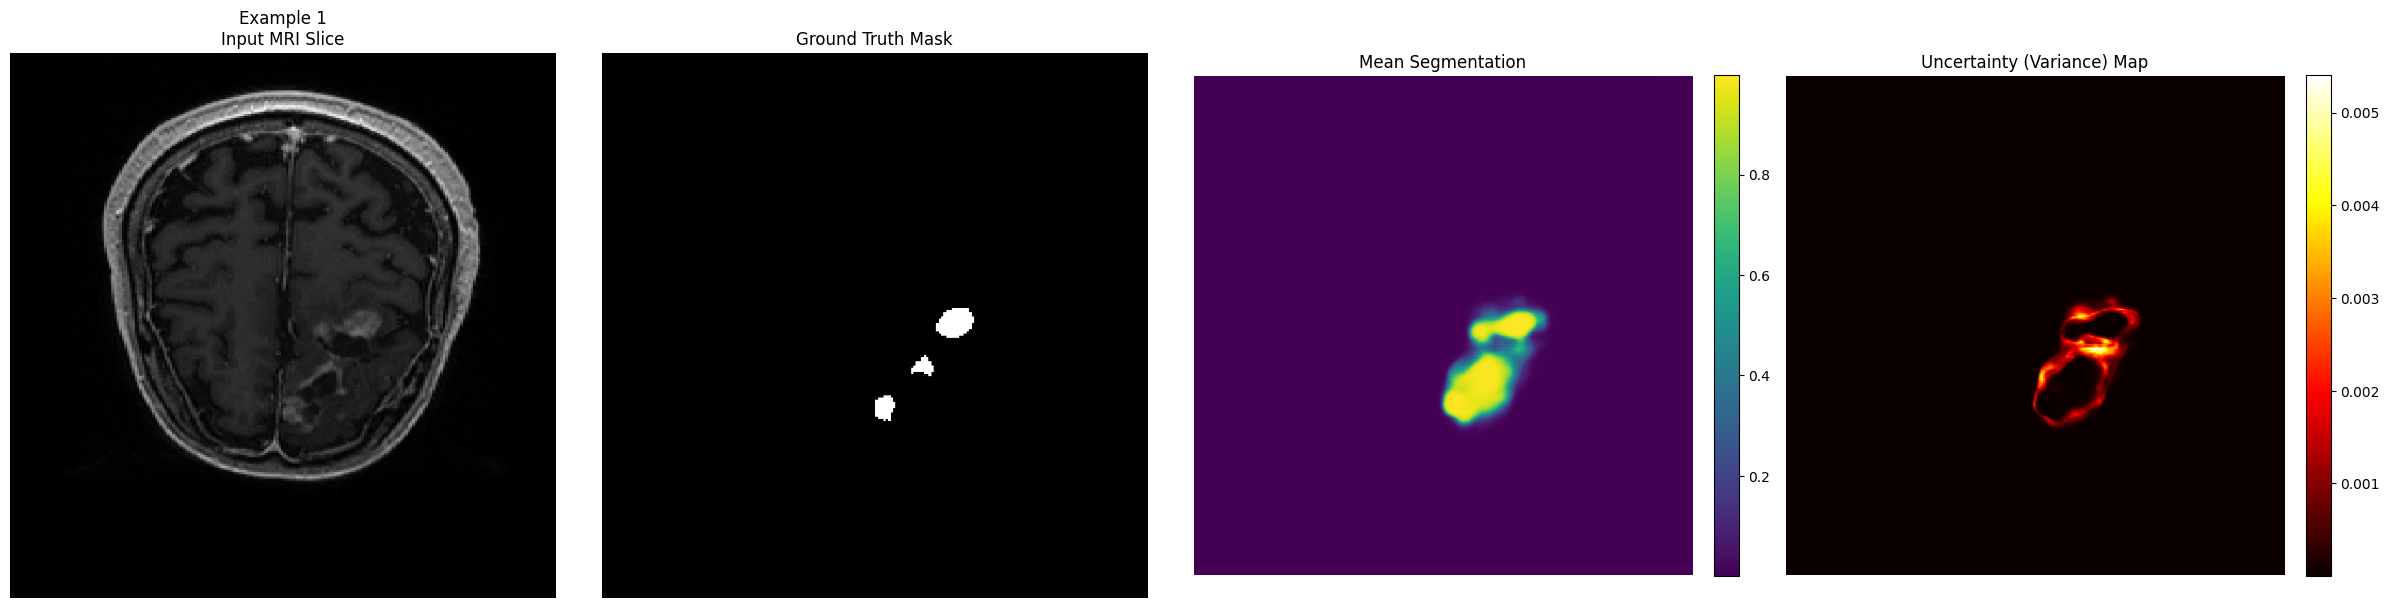

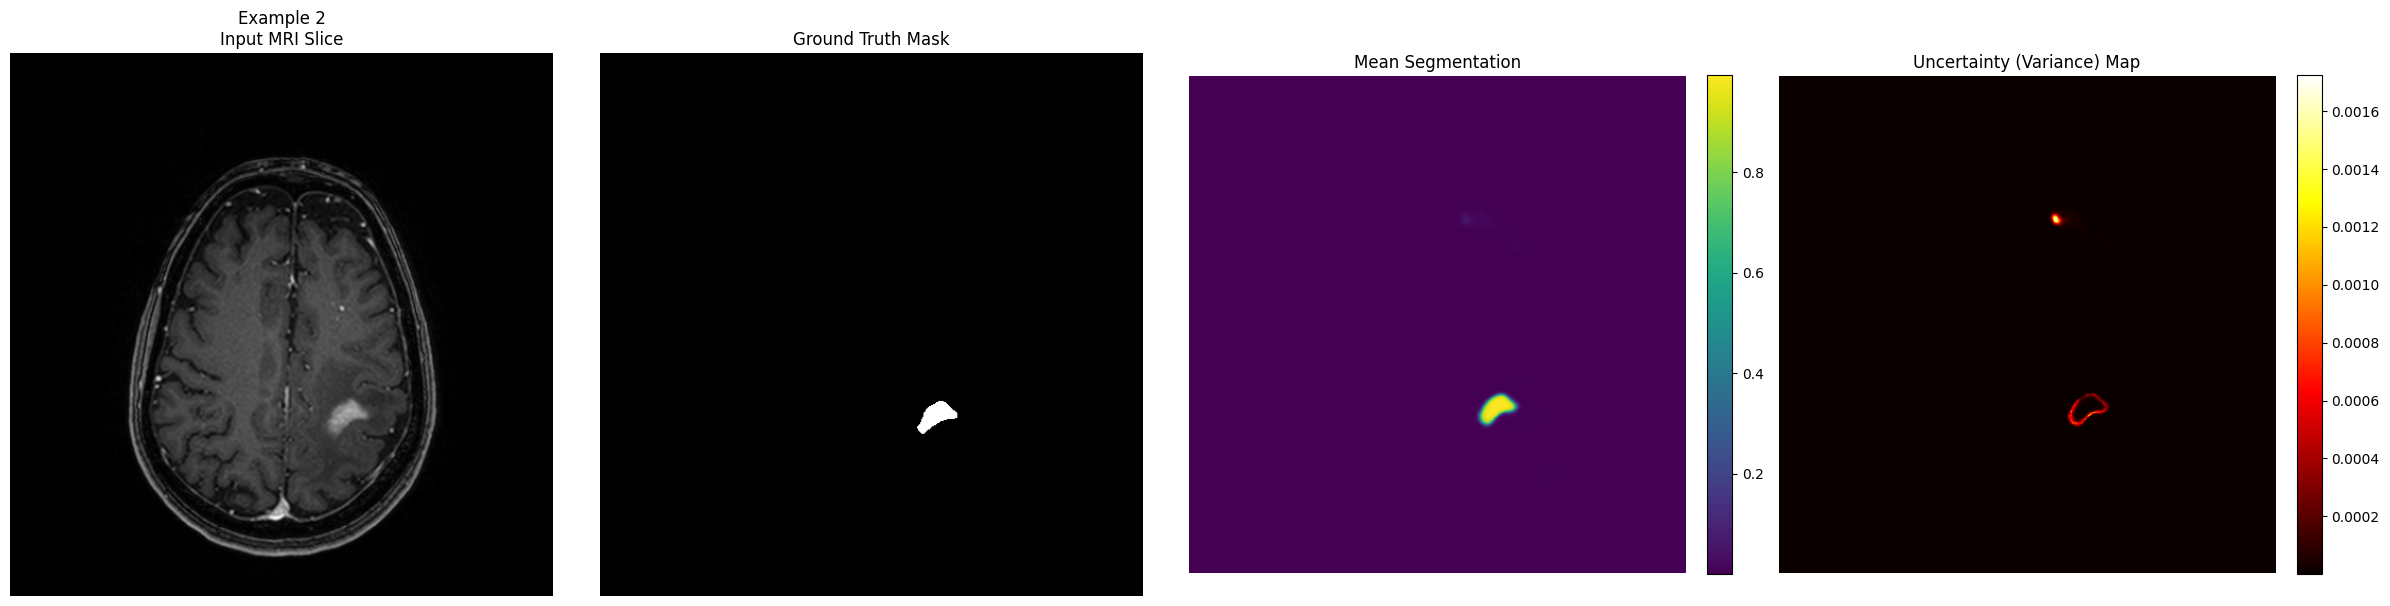

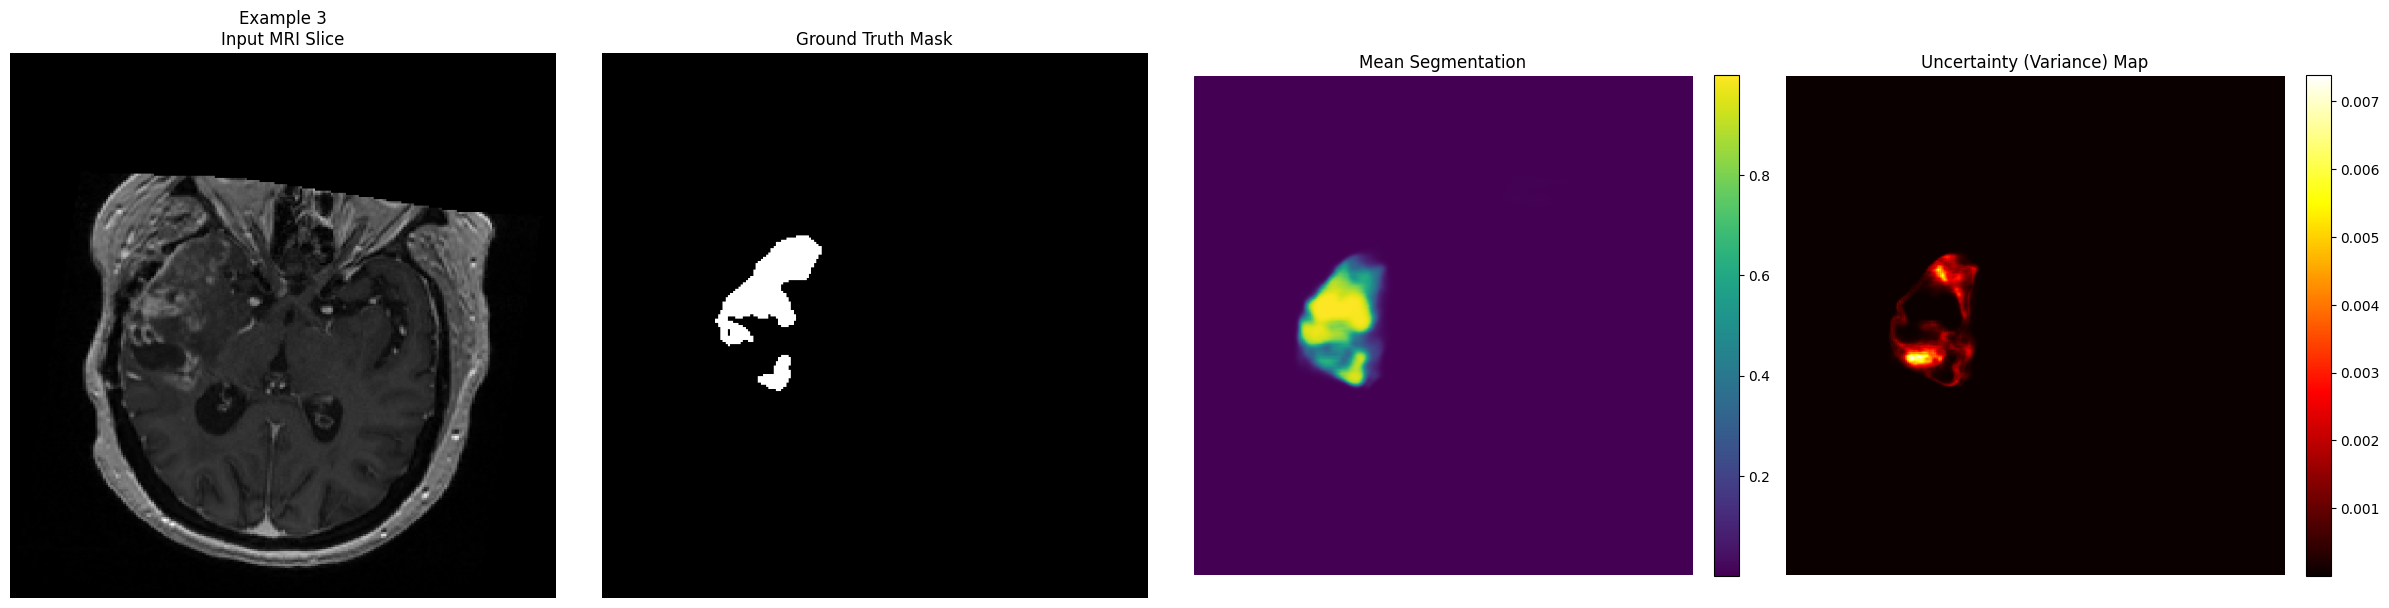

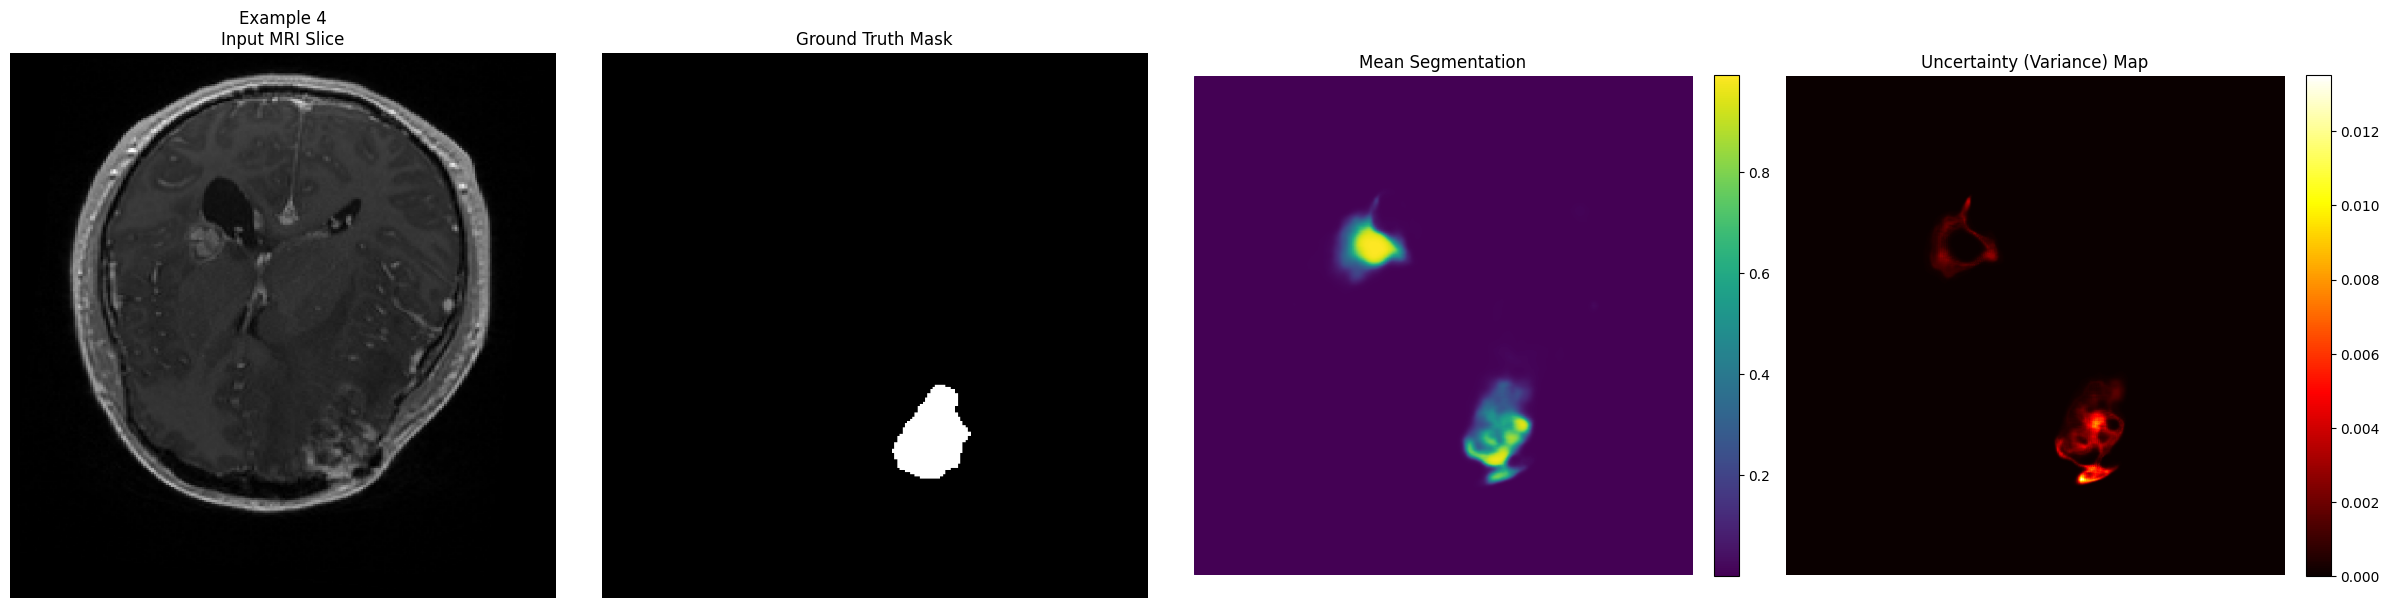

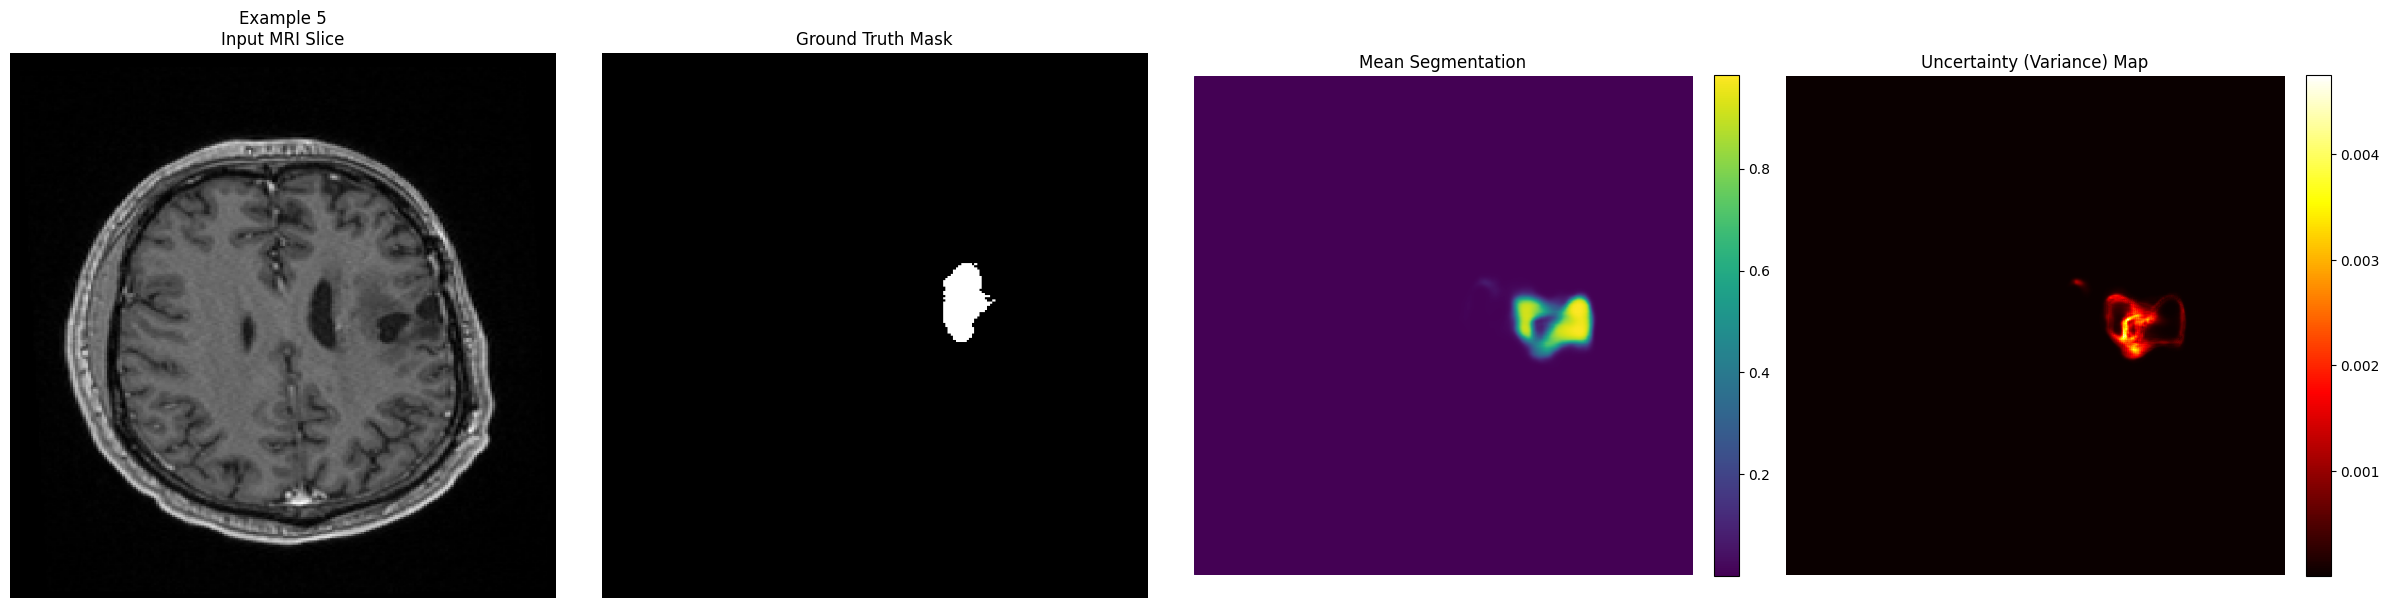

In [12]:
# Create a new loader to get a random batch for visualization
test_dataloader_single = DataLoader(test_dataset, batch_size=5, shuffle=True, num_workers=4)
input_img, true_mask, mean_pred, var_pred = mc_dropout_inference(model, test_dataloader_single, device, num_samples=50)

# Visualize the results
plot_segmentation_with_uncertainty(input_img, true_mask, mean_pred, var_pred, n=5)

In [13]:
def mc_dropout_inference(model, loader, device, num_samples=20):
    model.eval()
    enable_dropout(model) # Enable dropout layers for uncertainty estimation

    # Get a single batch from the loader
    input_img, true_mask = next(iter(loader))
    input_img, true_mask = input_img.to(device), true_mask.to(device)

    predictions = []
    with torch.no_grad():
        for _ in tqdm(range(num_samples), desc="MC Dropout Inference"):
            # Perform a forward pass
            logits = model(input_img)
            # Apply sigmoid to get probabilities and store them
            preds = torch.sigmoid(logits)
            predictions.append(preds)

    # Stack predictions along a new dimension to compute stats
    predictions = torch.stack(predictions)

    # Compute mean and variance across the samples
    mean_pred = predictions.mean(dim=0)
    var_pred = predictions.var(dim=0)

    return input_img, true_mask, mean_pred, var_pred

# Perform MC Dropout on a sample from the test set
test_dataloader_single = DataLoader(test_dataset, batch_size=11, shuffle=True, num_workers=4)
input_img, true_mask, mean_pred, var_pred = mc_dropout_inference(model, test_dataloader_single, device, num_samples=50)

MC Dropout Inference: 100%|██████████| 50/50 [00:01<00:00, 35.47it/s]


The uncertainty maps mostly highlight the tumor boundaries, which makes sense because these are the regions where the model struggles to decide between tumor and normal tissue. The central parts of large, solid tumors usually show very low uncertainty since they’re identifiable, while the periphery or infiltrative regions are more variable. In most cases, the uncertainty patterns overlap well with the tumor contours, confirming that the model recognizes ambiguous regions. However, in a few slices, some uncertainty also appears in areas with artifacts or poor contrast, suggesting that image quality still affects the model’s confidence.

## Evaluate Model Calibration

A good model should not only be accurate, but its confidence scores should be reliable. We will now plot a Reliability Diagram to check if the model's predicted probabilities align with its actual accuracy. An overconfident model's predictions are less trustworthy.

In [14]:
#@title helper function
from sklearn.calibration import calibration_curve

def plot_calibration_curve(pred_probs, true_labels, n_bins=15, title="Calibration Curve"):
    """
    Plots a reliability diagram and histogram, and computes the ECE.
    """
    # Ensure true_labels are integers for calibration_curve
    true_labels = true_labels.astype(int)

    # Calculate points for the reliability diagram
    # prob_true: The proportion of positive samples in each bin
    # prob_pred: The mean predicted probability in each bin
    prob_true, prob_pred = calibration_curve(true_labels, pred_probs, n_bins=n_bins, strategy='uniform')

    # Calculate the Expected Calibration Error (ECE)
    # Get the number of samples in each bin
    bin_totals = np.histogram(pred_probs, bins=n_bins, range=(0, 1))[0]

    # Filter out bins that have no samples
    non_empty_bins = bin_totals > 0

    # Calculate ECE only on non-empty bins
    ece = np.sum(
        (np.abs(prob_true[non_empty_bins] - prob_pred[non_empty_bins])) *
        (bin_totals[non_empty_bins] / bin_totals.sum())
    )

    # Set up the plot with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

    # Plot the reliability diagram
    ax1.plot(prob_pred, prob_true, "o-", label="Model")
    ax1.plot([0, 1], [0, 1], "--", color="gray", label="Perfect Calibration")
    ax1.set_ylabel("Fraction of positives (Accuracy)")
    ax1.set_title(f"{title} (ECE = {ece:.4f})")
    ax1.legend(loc="upper left")
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    ax1.grid(True, linestyle='--', alpha=0.6)

    # Plot the histogram of predicted probabilities
    ax2.hist(pred_probs, bins=n_bins, range=(0, 1), color="C0", edgecolor="black", density=False)
    ax2.set_xlabel("Mean predicted probability (Confidence)")
    ax2.set_ylabel("Count of samples")
    ax2.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

    return ece

# Function to get all predictions and labels for the entire test set
def get_all_preds_and_labels(model, loader, device):
    """ Gathers all predictions and ground truth labels from a data loader. """
    model.eval() # Ensure model is in standard eval mode for this
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, masks in tqdm(loader, desc="Gathering All Predictions"):
            imgs, masks = imgs.to(device), masks.to(device)
            logits = model(imgs)
            probs = torch.sigmoid(logits)
            all_preds.append(probs.cpu().numpy().flatten())
            all_labels.append(masks.cpu().numpy().flatten())

    return np.concatenate(all_preds), np.concatenate(all_labels)

Gathering All Predictions: 100%|██████████| 664/664 [00:09<00:00, 72.31it/s]



Plotting Reliability Diagram Before Calibration:


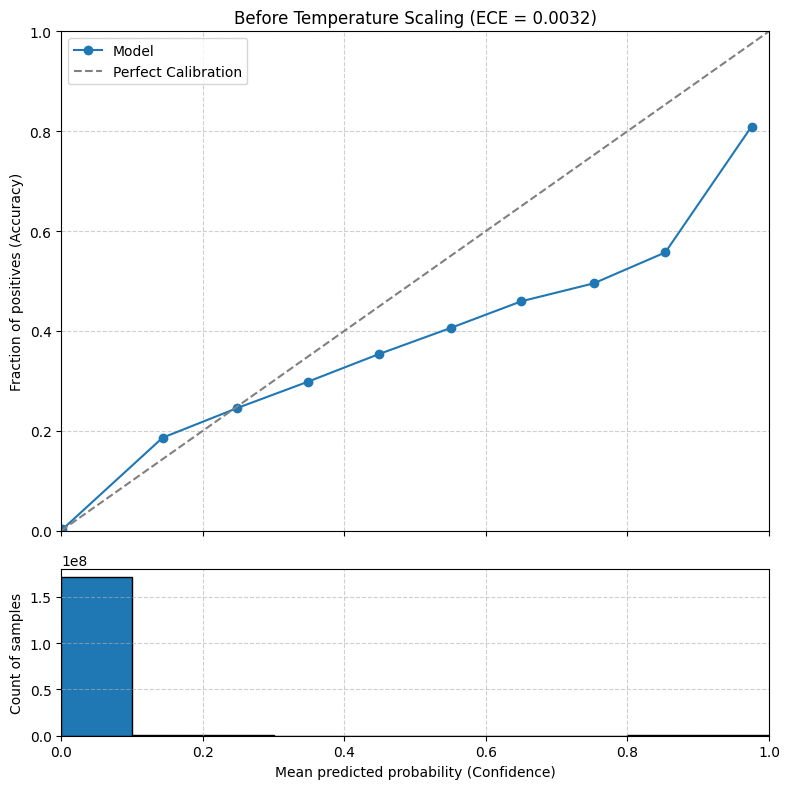

In [15]:
# Get predictions and labels for the test set
pred_probs, true_labels = get_all_preds_and_labels(model, test_dataloader, device)

print("\nPlotting Reliability Diagram Before Calibration:")
ece_before = plot_calibration_curve(pred_probs, true_labels, n_bins=10, title="Before Temperature Scaling")

Its main purpose is to answer one critical question: **Can I trust my model's confidence scores?**

Remember that top plot (the calibration curve) cannot be understood without the bottom plot (the histogram)

The histogram shows a gigantic bar on the far left, in the confidence range of 0.0 to 0.1. The other bars are almost zero in comparison. This tells you that for the vast majority of pixels, the model is giving a very low confidence score.

- **Why?** This is completely normal for medical segmentation! In a brain scan, most of the image is not a tumor. Your model is correctly and confidently saying "this pixel is not a tumor" for most of the image, which results in a low probability of it being a tumor.

However, for the few predictions where the model is more confident (the right side of the graph), the blue line is consistently below the dashed line.

- **Meaning**: When your model says, "I am 80% sure this pixel is a tumor," it is actually only correct 50% of the time. This is a classic sign of overconfidence.

The calibration curve shows that the model tends to be slightly overconfident—its predicted probabilities are higher than the actual observed accuracy. This means when the model outputs 0.9 confidence, the true correctness might be closer to 0.8. The large number of very low-confidence pixels in the histogram is expected because most of the image is background. To improve trust, temperature scaling or more balanced training could help, but overall, it’s best to interpret these confidence scores as relative indicators rather than truth.

## Try Calibration with Temperature Scaling
Our initial plot showed signs of overconfidence. Temperature Scaling is a common technique to correct this. It learns a single parameter ("temperature") on the validation set to "soften" the model's predictions, making them more reliable. We will apply this technique and then re-evaluate the calibration.

Wrap the model to include the temperature parameter

In [16]:
# Perform Temperature Scaling
class ModelWithTemperature(nn.Module):
    def __init__(self, model):
        super(ModelWithTemperature, self).__init__()
        self.model = model
        self.temperature = nn.Parameter(torch.ones(1, device=device) * 1.5)

    def forward(self, input):
        with torch.no_grad():
            logits = self.model(input)
        return logits / self.temperature

# Create the wrapped model and move it to the GPU
scaled_model = ModelWithTemperature(model)
scaled_model.to(device)
scaled_model.model.eval() # Set the base model to evaluation mode

UnetWithBottleneckDropout(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample

In [17]:
# Use the Adam optimizer to learn ONLY the temperature
optimizer = optim.Adam([scaled_model.temperature], lr=0.01)
nll_criterion = nn.BCEWithLogitsLoss().to(device)

print("Tuning temperature on validation set...")
for images, labels in tqdm(val_dataloader, desc="Optimizing Temperature"):
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    scaled_logits = scaled_model(images)
    loss = nll_criterion(scaled_logits, labels)
    loss.backward()
    optimizer.step()

optimal_temperature = scaled_model.temperature.item()
print(f'\nOptimal temperature found: {optimal_temperature:.3f}')


Tuning temperature on validation set...


Optimizing Temperature: 100%|██████████| 13/13 [00:02<00:00,  6.37it/s]


Optimal temperature found: 1.391


Applying Temperature: 100%|██████████| 664/664 [00:08<00:00, 81.04it/s]



Plotting Reliability Diagram After Calibration:


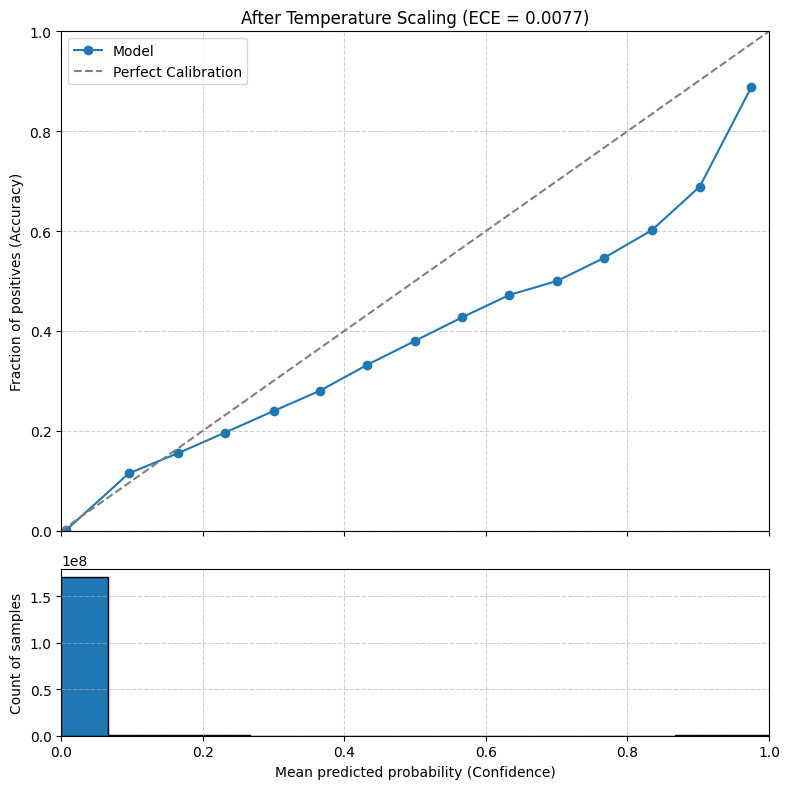

In [18]:
# Get the new, scaled predictions
def get_scaled_preds(model, loader, device, temperature):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for imgs, _ in tqdm(loader, desc="Applying Temperature"):
            imgs = imgs.to(device)
            logits = model(imgs)
            scaled_logits = logits / temperature
            probs = torch.sigmoid(scaled_logits)
            all_preds.append(probs.cpu().numpy().flatten())
    return np.concatenate(all_preds)

scaled_pred_probs = get_scaled_preds(model, test_dataloader, device, optimal_temperature)

# Plot the reliability diagram after scaling
print("\nPlotting Reliability Diagram After Calibration:")
ece_after = plot_calibration_curve(scaled_pred_probs, true_labels, n_bins=15, title="After Temperature Scaling")

## Quantifying Calibration with Expected Calibration Error (ECE)

While the reliability diagrams give us a great visual understanding of our model's calibration, the Expected Calibration Error (ECE) provides a single, quantitative metric to summarize it.

$$ \text{ECE} = \sum_{m=1}^{M} \frac{|B_m|}{n} |\text{acc}(B_m) - \text{conf}(B_m)| $$

ECE measures the weighted average difference between the model's confidence and its actual accuracy across a number of bins.

In [19]:
# Calculate ECE
def calculate_ece(pred_probs, true_labels, n_bins=10):
    # Create bin boundaries from 0 to 1
    bin_boundaries = np.linspace(0, 1, n_bins + 1)

    # Get the bin index for each prediction.
    # np.digitize is an efficient way to do this.
    bin_indices = np.digitize(pred_probs, bin_boundaries[1:-1])

    ece = 0.0

    for i in range(n_bins):
        # Create a boolean mask to select predictions in the current bin
        in_bin = bin_indices == i

        # If the bin is not empty, calculate its contribution to the ECE
        if np.any(in_bin):
            # Calculate the proportion of all samples that fall into this bin
            prop_in_bin = np.mean(in_bin)

            # Calculate the average accuracy for samples in this bin
            # This is the "Fraction of positives" from the reliability diagram
            accuracy_in_bin = np.mean(true_labels[in_bin])

            # Calculate the average confidence for samples in this bin
            # This is the "Mean predicted probability" from the reliability diagram
            confidence_in_bin = np.mean(pred_probs[in_bin])

            # Add the weighted absolute difference to the total ECE
            ece += np.abs(accuracy_in_bin - confidence_in_bin) * prop_in_bin

    return ece

In [20]:
# This cell assumes the 'calculate_ece' function is already defined
# and that 'pred_probs' and 'scaled_pred_probs' exist from previous cells.

ece_before_10_bins = calculate_ece(pred_probs, true_labels, n_bins=10)
ece_after_10_bins = calculate_ece(scaled_pred_probs, true_labels, n_bins=10)

print(f"Calculating ECE with M = 10 bins:")
print(f"  - ECE before Temperature Scaling: {ece_before_10_bins:.5f}")
print(f"  - ECE after Temperature Scaling:  {ece_after_10_bins:.5f}")

improvement = ece_before_10_bins - ece_after_10_bins
if improvement > 0:
    print(f"\nTemperature scaling improved the ECE by {improvement:.5f}.")
else:
    print(f"\nTemperature scaling did NOT improve the ECE (error increased by {-improvement:.5f}).")

Calculating ECE with M = 10 bins:
  - ECE before Temperature Scaling: 0.00317
  - ECE after Temperature Scaling:  0.00751

Temperature scaling did NOT improve the ECE (error increased by 0.00434).


We have established that our model's calibration did not improved, especially considering the vast number of background pixels. We also discovered that post-hoc calibration with temperature scaling is not beneficial for this model.

## Use Uncertainty to Find and Analyze Difficult Cases
Since temperature scaling didn't help, the most practical use of uncertainty is to identify cases the model is likely to fail on. We'll run MC Dropout on the entire test set and find the images with the highest average uncertainty. We will then check if high uncertainty correlates with low Dice scores.

## Calculating Uncertainty Across the Entire Test Set

<div class="alert alert-block alert-info">
<b>Q1.</b>  Why is uncertainty estimation especially important in medical image segmentation compared to standard classification tasks?
</div>

In [21]:
from tqdm import tqdm
import numpy as np

def get_mc_dropout_predictions(model, loader, device, num_samples=20):
    """
    Performs MC Dropout inference on an entire dataset.
    """
    model.eval()
    enable_dropout(model) # Assumes 'enable_dropout' function is defined from earlier

    results = []

    for img, mask in tqdm(loader, desc="MC Inference on Test Set"):
        img, mask = img.to(device), mask.to(device)

        predictions = []
        with torch.no_grad():
            for _ in range(num_samples):
                preds = torch.sigmoid(model(img))
                predictions.append(preds)

        predictions = torch.stack(predictions)
        mean_pred = predictions.mean(dim=0)
        var_pred = predictions.var(dim=0)

        # Calculate the average variance for this slice (a single uncertainty score)
        avg_variance = var_pred.mean().item()

        # Store everything we need for later analysis
        results.append({
            'image': img.cpu(),
            'mask': mask.cpu(),
            'mean_pred': mean_pred.cpu(),
            'variance_map': var_pred.cpu(),
            'avg_variance': avg_variance
        })

    return results

# Create a DataLoader with batch_size=1 to process one image at a time
test_dataloader_single = DataLoader(test_dataset, batch_size=1, shuffle=False)

# This will take some time to run
mc_results = get_mc_dropout_predictions(model, test_dataloader_single, device, num_samples=25)

# Sort the results by the average variance in descending order
mc_results.sort(key=lambda x: x['avg_variance'], reverse=True)

print(f"\nCompleted MC Dropout on {len(mc_results)} test samples.")
print(f"Most uncertain case has average variance: {mc_results[0]['avg_variance']:.6f}")
print(f"Least uncertain case has average variance: {mc_results[-1]['avg_variance']:.6f}")

MC Inference on Test Set: 100%|██████████| 664/664 [02:14<00:00,  4.93it/s]


Completed MC Dropout on 664 test samples.
Most uncertain case has average variance: 0.000141
Least uncertain case has average variance: 0.000000


In segmentation, every pixel carries diagnostic importance, especially when defining tumor margins or critical structures. A small region of error can have major clinical implications, unlike image classification where you only predict one label per image. Medical images also tend to have blurry boundaries, heterogeneous textures, and class imbalance, making uncertainty an essential measure of reliability. Knowing where the model is unsure helps clinicians verify ambiguous regions instead of blindly trusting the output.

## Identifying and Analyzing the Most Uncertain Cases
Now that we have sorted our results from most to least uncertain, we can visualize the top 5 cases that the model "struggled" with the most. We expect these to be ambiguous images, perhaps with poorly defined tumor boundaries or unusual anatomy, which would justify flagging them for an expert.

In [22]:
#@title helper
from tqdm import tqdm
import numpy as np
import torch
# First, we need a function to calculate Dice score on single numpy arrays
def dice_score_numpy(pred, target, smooth=1e-6):
    pred_flat = (pred > 0.5).flatten()
    target_flat = (target > 0.5).flatten()
    intersection = (pred_flat & target_flat).sum()
    union = pred_flat.sum() + target_flat.sum()
    return (2. * intersection + smooth) / (union + smooth)

# This helper function is required by get_mc_dropout_predictions
def enable_dropout(model):
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()

def get_mc_dropout_predictions(model, loader, device, num_samples=20):
    # Set the model to evaluation mode but enable dropout for uncertainty estimation
    model.eval()
    enable_dropout(model)

    results = []

    # Iterate through every sample in the provided dataloader
    for img, mask in tqdm(loader, desc="MC Inference on Test Set"):
        img, mask = img.to(device), mask.to(device)

        predictions = []
        with torch.no_grad():
            # Perform N stochastic forward passes
            for _ in range(num_samples):
                # We apply sigmoid here to get probabilities directly
                preds = torch.sigmoid(model(img))
                predictions.append(preds)

        # Stack predictions along a new dimension to compute stats
        # Shape becomes: [num_samples, batch_size, C, H, W]
        predictions = torch.stack(predictions)

        # Compute mean and variance across the samples (dimension 0)
        mean_pred = predictions.mean(dim=0)
        var_pred = predictions.var(dim=0)

        # Calculate a single summary score for uncertainty for this slice
        # This makes it easy to sort and find the "most uncertain" images
        avg_variance = var_pred.mean().item()

        # Store everything we need for later analysis, moving data to CPU
        # to prevent VRAM from filling up.
        results.append({
            'image': img.cpu(),
            'mask': mask.cpu(),
            'mean_pred': mean_pred.cpu(),
            'variance_map': var_pred.cpu(),
            'avg_variance': avg_variance
        })

    return results


def plot_most_uncertain_cases(results, num_cases=5):
    print(f"Displaying the {num_cases} most uncertain predictions...")

    # Loop through the top N cases
    for i in range(min(num_cases, len(results))):
        case = results[i]

        # Extract the numpy arrays from the dictionary
        img = case['image'][0, 0]        # [batch, channel, H, W] -> [H, W]
        mask = case['mask'][0, 0]
        mean_pred = case['mean_pred'][0, 0]
        var_map = case['variance_map'][0, 0]
        avg_var = case['avg_variance']

        # Set up a figure with 4 subplots in a row
        fig, axes = plt.subplots(1, 4, figsize=(22, 6))
        fig.suptitle(f"Case #{i+1} Most Uncertain - Average Variance: {avg_var:.6f}", fontsize=16)

        # Plot 1: Original Input Image
        axes[0].imshow(img, cmap='gray')
        axes[0].set_title('Input MRI Slice')
        axes[0].axis('off')

        # Plot 2: Ground Truth Segmentation
        axes[1].imshow(mask, cmap='gray')
        axes[1].set_title('Ground Truth')
        axes[1].axis('off')

        # Plot 3: Mean Prediction (the model's best guess)
        im_pred = axes[2].imshow(mean_pred, cmap='viridis')
        axes[2].set_title('Mean Prediction')
        axes[2].axis('off')
        fig.colorbar(im_pred, ax=axes[2], fraction=0.046, pad=0.04)

        # Plot 4: Uncertainty Map (Variance)
        im_var = axes[3].imshow(var_map, cmap='hot')
        axes[3].set_title('Uncertainty (Variance) Map')
        axes[3].axis('off')
        fig.colorbar(im_var, ax=axes[3], fraction=0.046, pad=0.04)

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

This runs MC Dropout on the entire test set and may take a couple of minutes

MC Inference on Test Set: 100%|██████████| 14/14 [05:38<00:00, 24.15s/it]


Displaying the 5 most uncertain predictions...


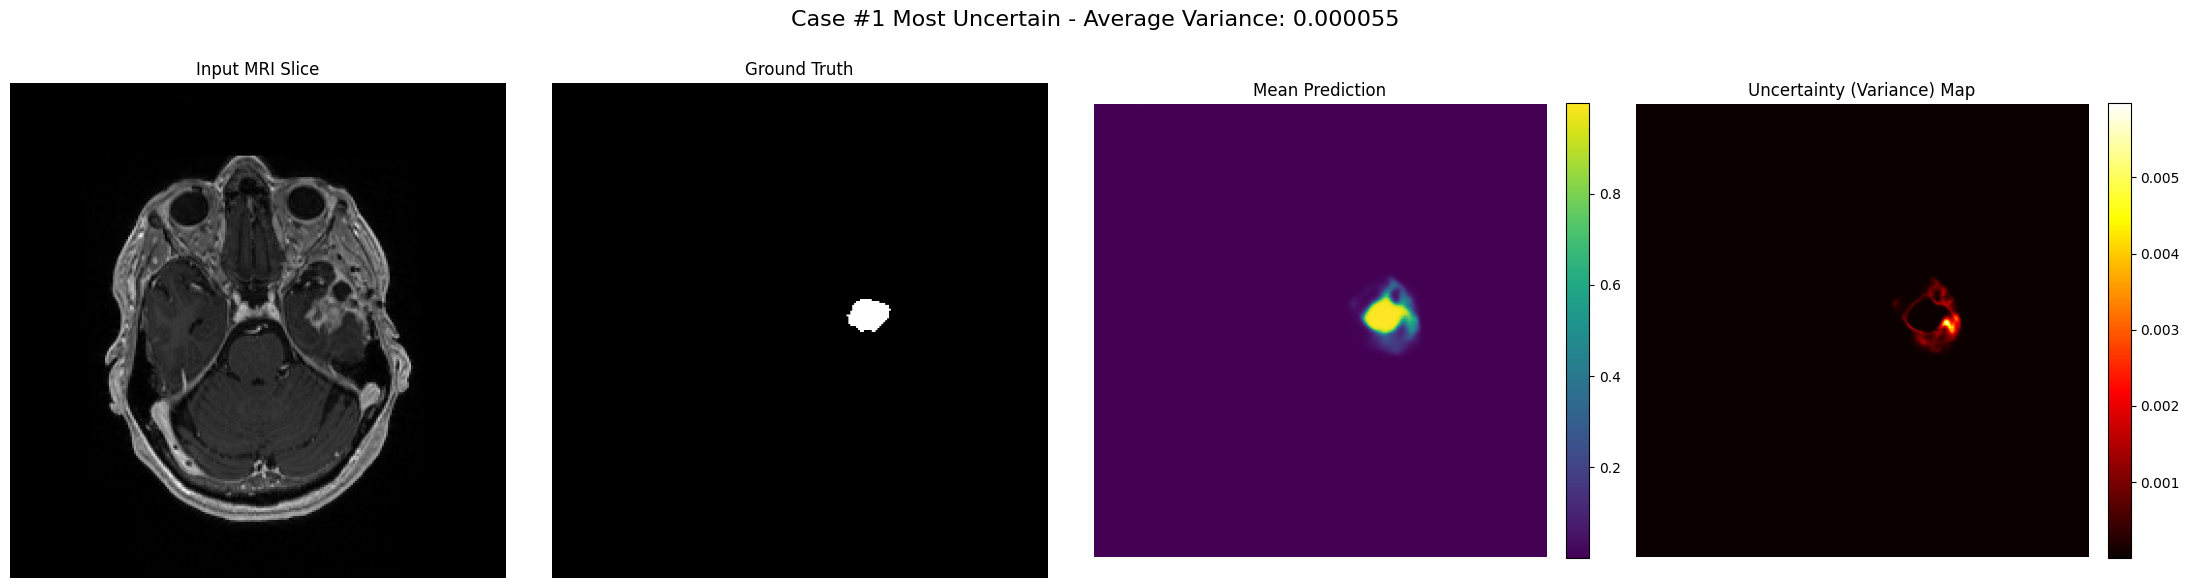

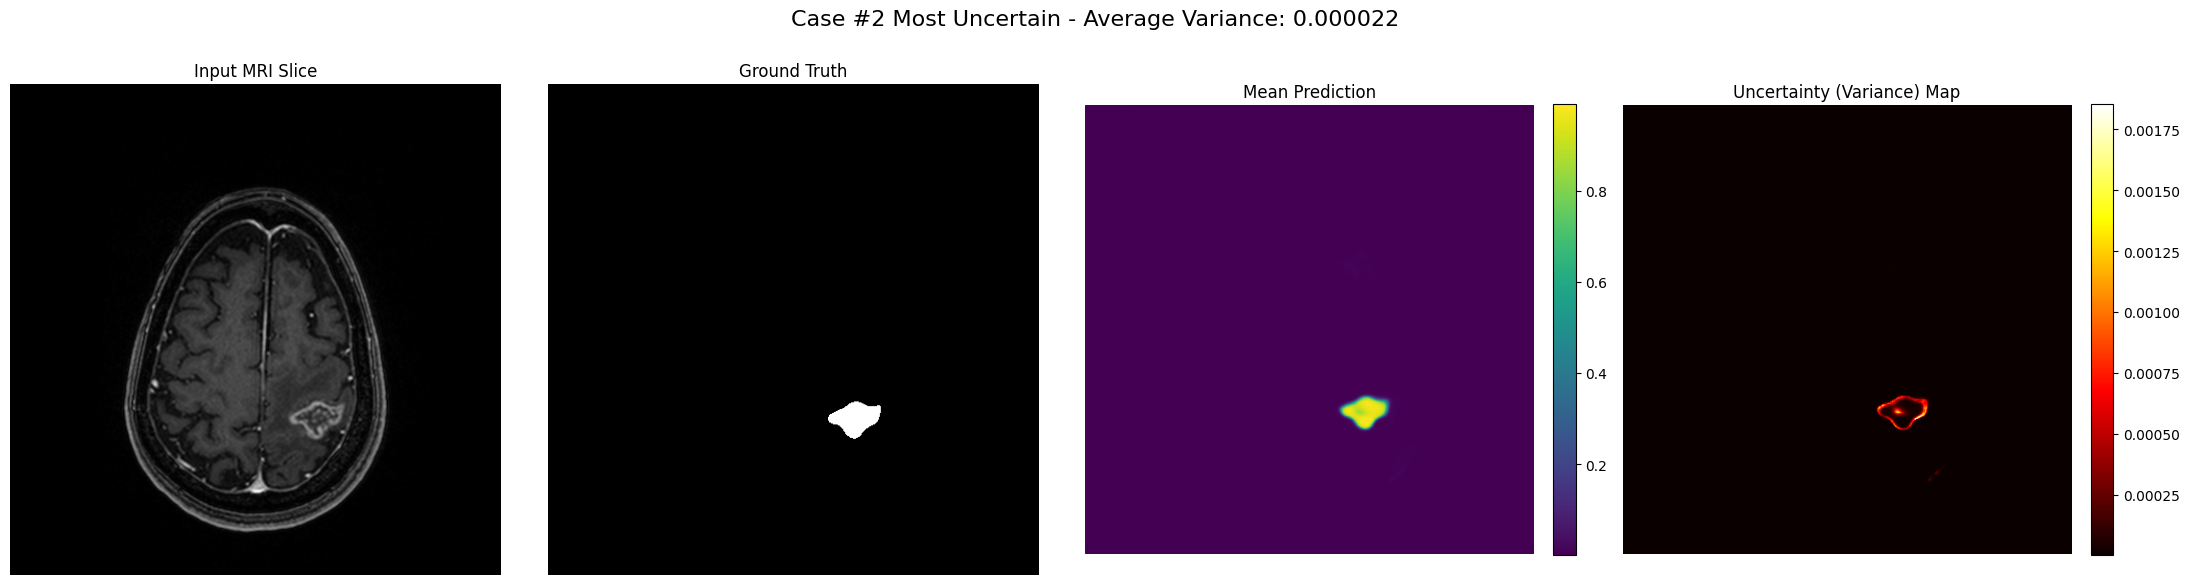

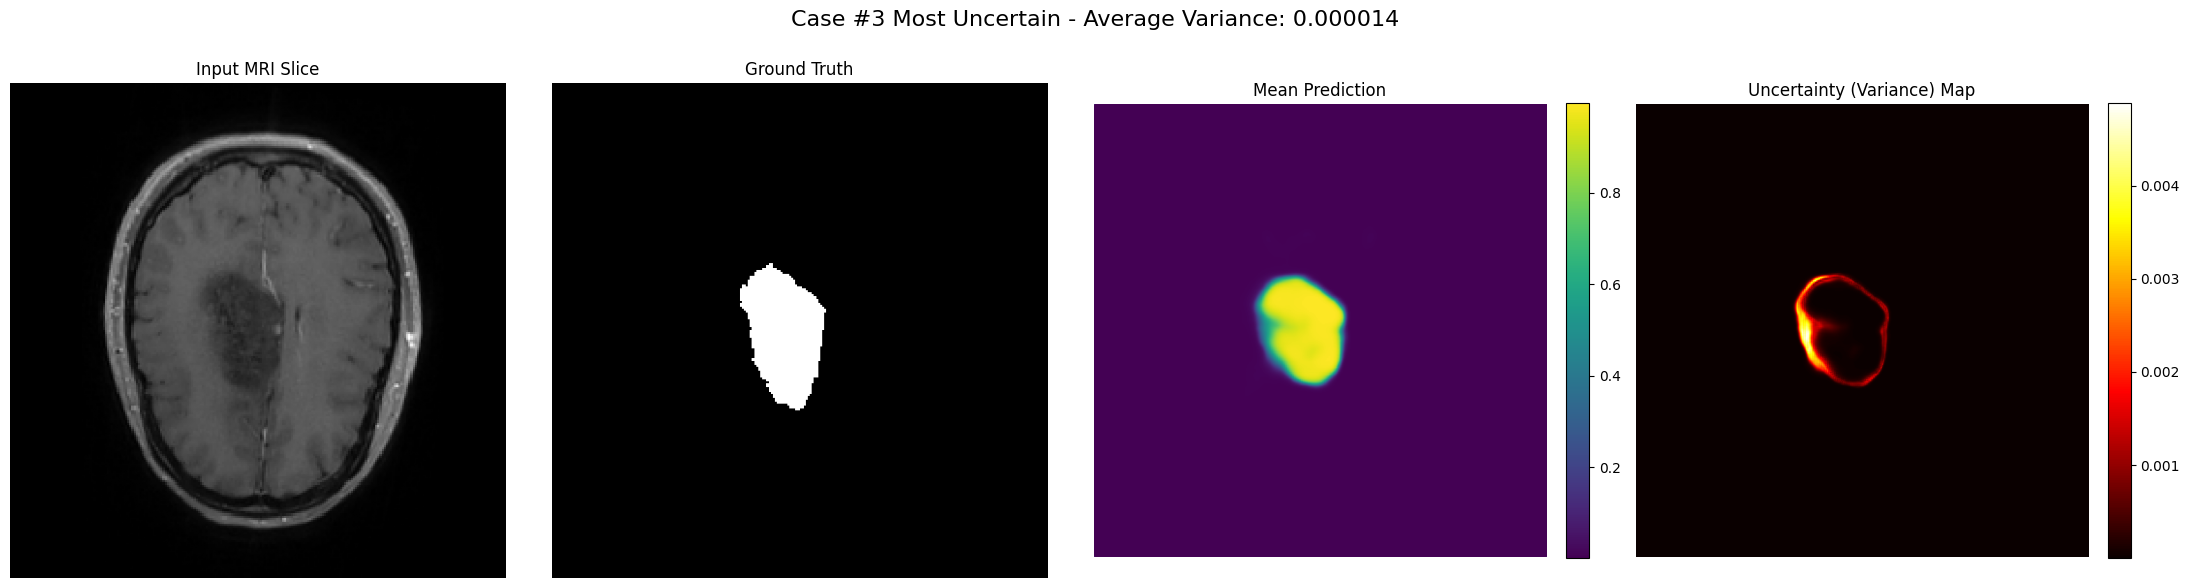

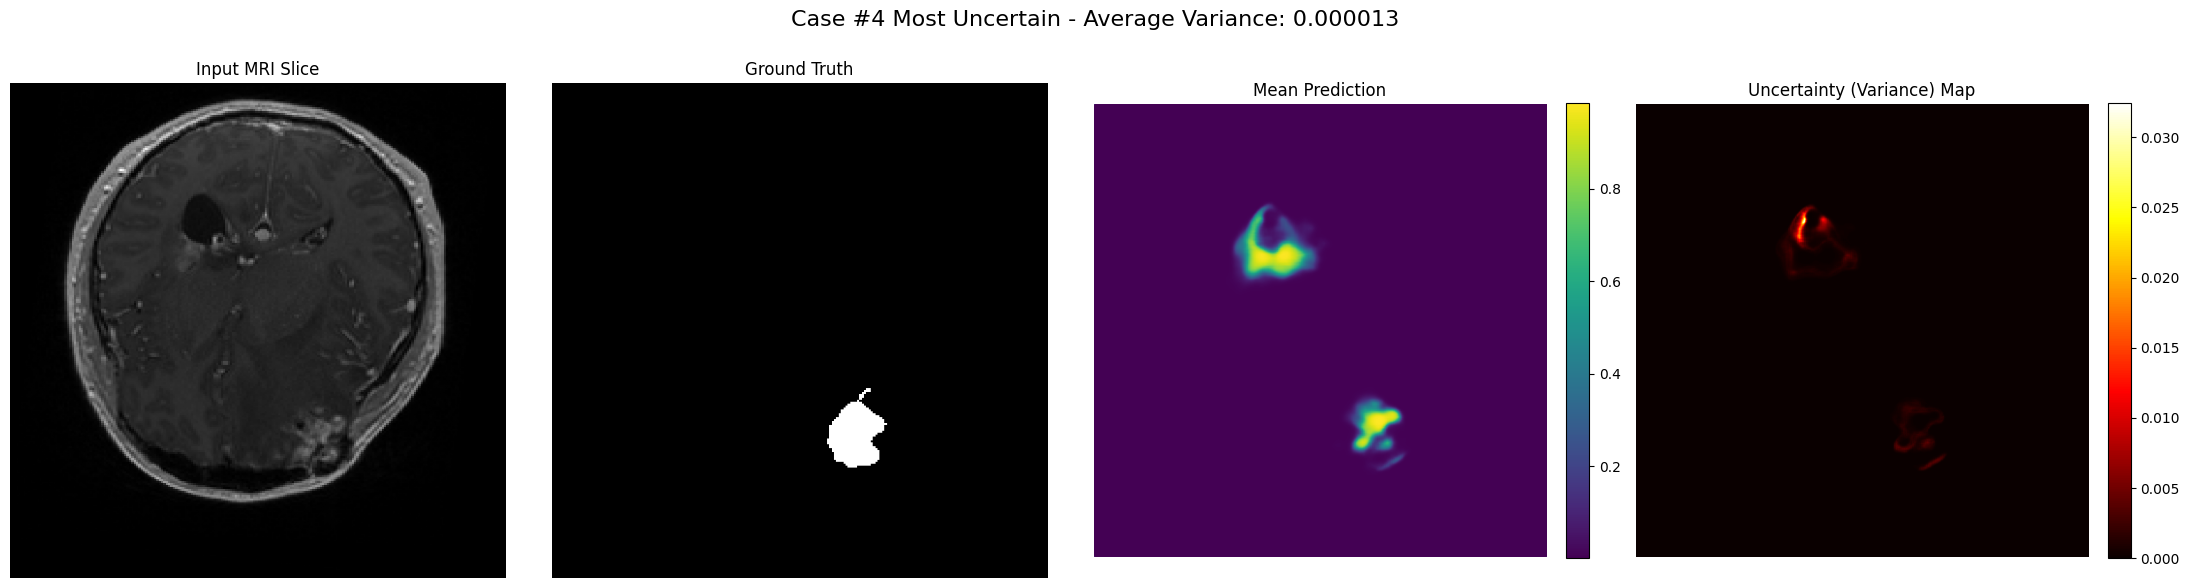

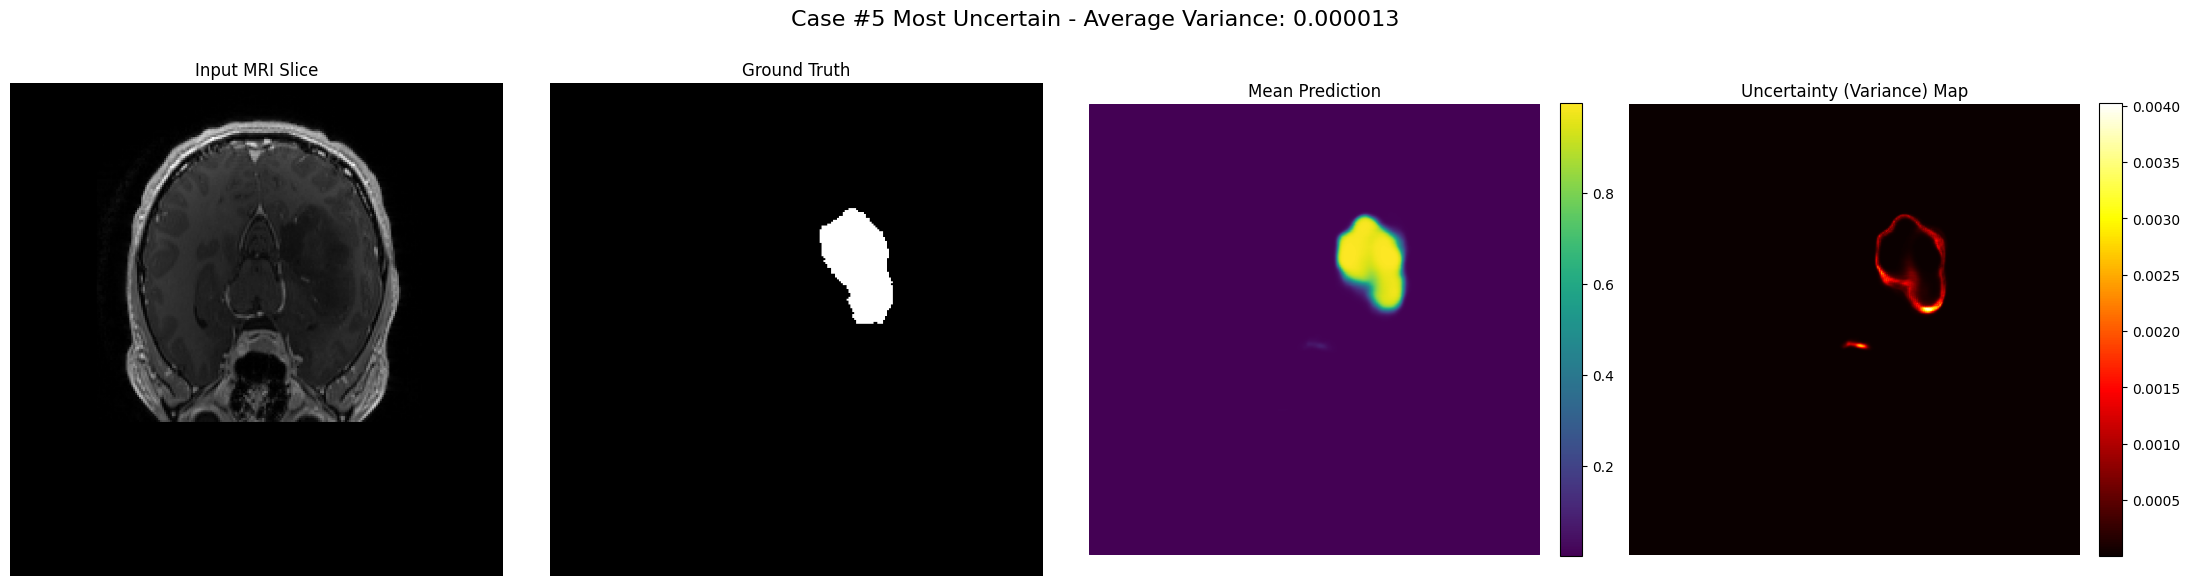

In [23]:
# Create a DataLoader with batch_size=1 to process one image at a time
test_dataloader_single = DataLoader(test_dataset, batch_size=50, shuffle=False)
mc_results = get_mc_dropout_predictions(model, test_dataloader_single, device, num_samples=200)

# Sort the results by the average variance in descending order
mc_results.sort(key=lambda x: x['avg_variance'], reverse=True)

# Visualize the most uncertain cases
plot_most_uncertain_cases(mc_results, num_cases=5)



<div class="alert alert-block alert-info">
<b>Q3.</b> In your visualization, do regions of high uncertainty correspond to anatomically complex areas or data boundaries?
</div>

If I were a radiologist, I’d use the uncertainty maps as a visual guide to double-check regions the model finds ambiguous. For instance, if the boundary between tumor and surrounding edema shows high uncertainty, I’d review that area manually before making volume measurements or planning radiation margins. In practice, if a model flagged a high-uncertainty area near critical structures like the optic chiasm or motor cortex, that could directly influence surgical planning—prompting additional imaging, a second reader review, or a more conservative resection plan. Essentially, uncertainty would help me prioritize where human oversight is most needed.

Think of a clinical setting:
If you were a radiologist using this segmentation model, how would you use the uncertainty map in your decision-making? Can you identify a case where high uncertainty could change the course of treatment?

If I were a radiologist, I’d use the uncertainty maps as a visual guide to double-check regions the model finds ambiguous. For instance, if the boundary between tumor and surrounding edema shows high uncertainty, I’d review that area manually before making volume measurements or planning radiation margins. In practice, if a model flagged a high-uncertainty area near critical structures like the optic chiasm or motor cortex, that could directly influence surgical planning—prompting additional imaging, a second reader review, or a more conservative resection plan. Essentially, uncertainty would help me prioritize where human oversight is most needed.

 ## Correlating Uncertainty with Model Error

Let's test our hypothesis directly. If our uncertainty metric is useful, we should see a negative correlation between uncertainty and performance. In other words, as average variance goes up, the Dice score should go down.

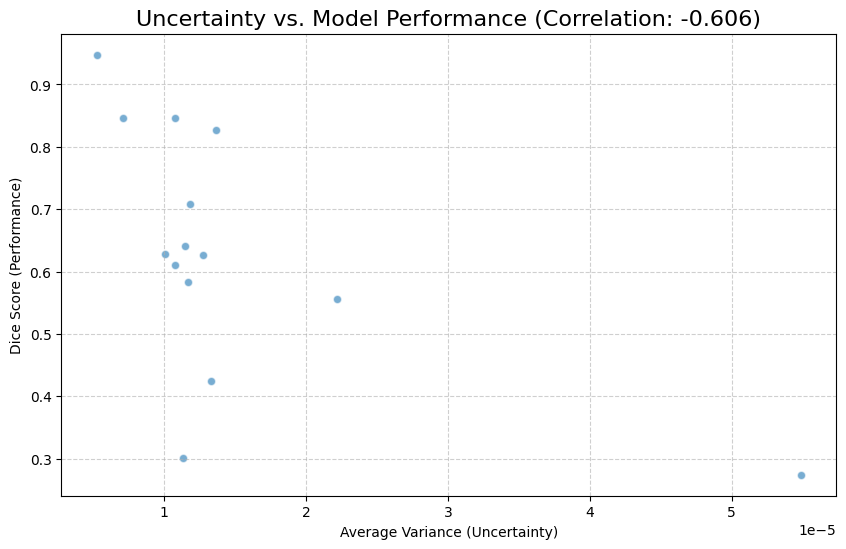

In [24]:
# Calculate Dice for every result
for case in mc_results:
    dice = dice_score_numpy(case['mean_pred'].numpy(), case['mask'].numpy())
    case['dice_score'] = dice

# Now, extract the data for plotting
variances = [case['avg_variance'] for case in mc_results]
dice_scores = [case['dice_score'] for case in mc_results]

# Calculate the Pearson correlation coefficient
correlation = np.corrcoef(variances, dice_scores)[0, 1]

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(variances, dice_scores, alpha=0.6, edgecolors='w')
plt.title(f'Uncertainty vs. Model Performance (Correlation: {correlation:.3f})', fontsize=16)
plt.xlabel('Average Variance (Uncertainty)')
plt.ylabel('Dice Score (Performance)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()